# Image Style Transfer

Style Transfer with Deep Neural Networks
In this notebook, we’ll recreate a style transfer method that is outlined in the paper, Image Style Transfer Using Convolutional Neural Networks, by Gatys in PyTorch.

In this paper, style transfer uses the features found in the 19-layer VGG Network, which is comprised of a series of convolutional and pooling layers, and a few fully-connected layers. In the image below, the convolutional layers are named by stack and their order in the stack. 


### Separating Style and Content
Style transfer relies on separating the content and style of an image. Given one content image and one style image, we aim to create a new, target image which should contain our desired content and style components:

- objects and their arrangement are similar to that of the content image
- style, colors, and textures are similar to that of the style image

An example is shown below, where the content image is of a cat, and the style image is of Hokusai's Great Wave. The generated target image still contains the cat but is stylized with the waves, blue and beige colors, and block print textures of the style image!


In this notebook, we'll use a pre-trained VGG19 Net to extract content or style features from a passed in image. We'll then formalize the idea of content and style losses and use those to iteratively update our target image until we get a result that we want. 

### Packages/ Libraries

In [1]:
# image io
from PIL import Image
from io import BytesIO
import requests

# visualisation/plotting
% pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# pytorch
import torch
import torch.optim as optim
from torchvision import transforms, models

Populating the interactive namespace from numpy and matplotlib


In [0]:
# determine device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Load in Style and Content Images
You can load in any images you want!

Additionally, it will be easier to have smaller images and to squish the content and style images so that they are of the same size.

In [21]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving IMG_1376.jpg to IMG_1376.jpg
Saving lightnight.jpeg to lightnight.jpeg
User uploaded file "IMG_1376.jpg" with length 2094665 bytes
User uploaded file "lightnight.jpeg" with length 175109 bytes


In [0]:
def load_image(img_url, max_size=350, shape=None):
    """Load image from specified url/filepath. The image then is resized(scaled) to
    be kept not too big thus normalised following standard VGG19 input mean, std.
    
    Args:
        img_url (str): url/path to image. if `http` or `https` is specified, will
            download the image from HTTP request
        max_size (int): max size of image.
    """
    # download from http or load from local
    if 'http' in img_url:
        response = requests.get(img_url)
        if not (response.status_code in [200, 201, 202, 204]):
            from requests.exceptions import HTTPError
            raise HTTPError
        image = Image.open(BytesIO(response.content)).convert('RGB')
    
    else:
        image = Image.open(img_url).convert('RGB')
    
    # calculate output img size
    size = min(max(image.size), max_size)
    size = shape if shape else (size,size)
    
    # define and apply transformation
    transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.485, 0.456, 0.406),
                             std=(0.229, 0.224, 0.225))
    ])
    
    # discard alpha channels if there is, 
    # unsqueeze in case only 1 img (batch_size=1)
    image = transform(image)[:3, : ,:].unsqueeze(0) 
    return image

In [0]:
# content and style
content_img = load_image('anna.png').to(device)
style_img = load_image('lightnight.jpeg').to(device)

In [29]:
content_img.shape, style_img.shape

(torch.Size([1, 3, 350, 350]), torch.Size([1, 3, 350, 350]))

In [0]:
# helper function for un-normalizing an image 
# and converting it from a Tensor image to a NumPy image for display
def im_convert(tensor):
    """ Display a tensor as an image. """
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

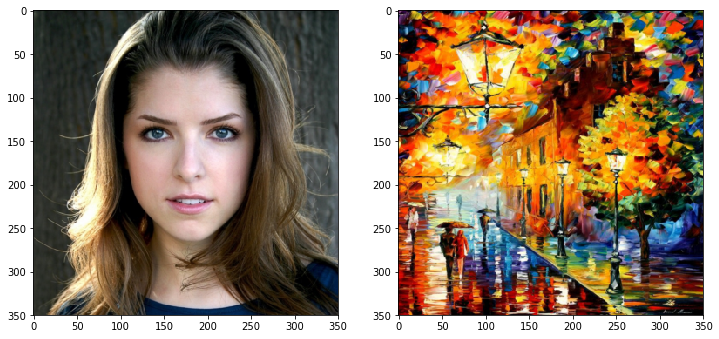

In [30]:
# plot content and style image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 10))
ax1.imshow(im_convert(content_img))
ax2.imshow(im_convert(style_img))

### Load in VGG19 features
VGG19 is split into two portions:

- vgg19.features, which are all the convolutional and pooling layers
- vgg19.classifier, which are the three linear, classifier layers at the end

We only need the features portion, which we're going to load in and "freeze" the weights of, below.

In [0]:
# load vgg19 features
vgg = models.vgg19(pretrained=True).features

In [0]:
# turn off vgg 19 training
for params in vgg.parameters(): 
    params.requires_grad_(False)

In [11]:
# move the model to GPU ready if available
vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): MaxPool2d(kernel_size=2, stride=2, padding=0, 

### VGG19 Layers 

In [12]:
# vgg19 features layers a.k.a convolutional layers
print(vgg)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): MaxPool2d(kernel_size=2, stride=2, padding=0, 

In [13]:
vgg._modules.items()

odict_items([('0', Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('1', ReLU(inplace)), ('2', Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('3', ReLU(inplace)), ('4', MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)), ('5', Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('6', ReLU(inplace)), ('7', Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('8', ReLU(inplace)), ('9', MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)), ('10', Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('11', ReLU(inplace)), ('12', Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('13', ReLU(inplace)), ('14', Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('15', ReLU(inplace)), ('16', Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('17', ReLU(inplace)), ('18', MaxPool2d(kernel_size=2, str

### Content Reconstruction
We can visualise the information at different processing stages in the CNN by reconstructing the input image from only knowing the network’s responses in a particular layer. We reconstruct the input image from from layers `conv1_2` (a), `conv2_2` (b), `conv3_2` (c), `conv4_2` (d) and `conv5_2` (e) of the original VGG-Network. 



In [0]:
from collections import OrderedDict

def get_features(images, model, chosen_layers=None):
    """Forward feed input image to each sequential modules in model and
    get the feature maps if it is specified in layers.
       
    Args:
        images (tensor of shape <batch_size,3,width,height>): input torch.Tensor images
        
        model (nn.Models): deep learning models with pre-trained weight
        
        chosen_layers (dictionary): map targeted module._modules' indices to prefered name.  
            If none, then will assume model is vgg19 and use modules specified in paper:
            https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf
   
    Returns:
        features (ordered_dict of <name: feature_map>)
    """
    x = images
    features = OrderedDict()
    
    # if none, default layers selected and naming convention 
    # as in cvpr_2016 paper
    if not chosen_layers:
        chosen_layers = {
            '0': 'conv1_1',
            '5': 'conv2_1',
            '10': 'conv3_1',
            '19': 'conv4_1',
            '21': 'conv4_2',
            '28': 'conv5_1',
        }
    
    # feed forward each layers
    for indices, layer in model._modules.items():
        x = layer(x)
        if indices in chosen_layers:
            features[chosen_layers[indices]] = x
    
    return features


### Gram Matrix
The output of every convolutional layer is a Tensor with dimensions associated with the batch_size, a depth, d and some height and width (h, w). The Gram matrix of a convolutional layer can be calculated as follows:

- Get the depth, height, and width of a tensor using batch_size, d, h, w = tensor.size()
- Reshape that tensor so that the spatial dimensions are flattened

Calculate the gram matrix by multiplying the reshaped tensor by it's transpose
Note: You can multiply two matrices using torch.mm(matrix1, matrix2).

In [0]:
def gram_matrix(feature_maps):
    """Apply gram matrix for feature_maps input.
    
    Args:
        feature_maps: 4D torch.Tensor of batch_size x channel_size x height x width
    
    Returns:
        gram matrix: 2D tensor of size x channel_size 
    """
    batch_size, channel_size, height, width = feature_maps.shape
    
    x = feature_maps.view(batch_size*channel_size, -1)
    return torch.mm(x, x.t())

## Training Style Transfer Network
Now that we've written functions for extracting features and computing the gram matrix of a given convolutional layer; let's put all these pieces together! We'll extract our features from our images and calculate the gram matrices for each layer in our style representation.

In [0]:
# get features
content_feats = get_features(content_img, vgg)
style_feats = get_features(style_img, vgg)

# initialise target_img from content_img
target_img = content_img.clone().requires_grad_(True).to(device)

### Style Reconstruction and Layer Weighting

On top of the original CNN activations we use a feature space that captures the texture information of an input image. The style representation computes correlations between the different features in different layers of the CNN. The CVPR_2016 paper reconstruct the style of the input image from a style representation built on different subsets of CNN layers.  

For this demonstration, we will only use style reconstruction: `conv1_1`, `conv2_1`, `conv3_1`, `conv4_1` and `conv5_1`. 

### Content : Style Ratio
Just like in the paper, we define an alpha (content_weight) and a beta (style_weight). This ratio will affect how stylized your final image is. It's recommended that you leave the ratio 1e-2 or more

In [0]:
# define style layer weighting, subset of chosen layers
content_layer = 'conv4_2'
style_weighted_layers = {
    'conv1_1': 1,
    'conv2_1': 0.75,
    'conv3_1': 0.2,
    'conv4_1': 0.2,
    'conv5_1': 0.2,
}

# Alpha-Beta (Content-Style) ratio
ab_ratio = 1e-6

## Updating and Calculating the Loss

You'll decide on a number of steps for which to update your image, this is similar to the training loop that you've seen before, only we are changing our target image and nothing else about VGG19 or any other image. Therefore, the number of steps is really up to you to set! I recommend using at least 2000 steps for good results. But, you may want to start out with fewer steps if you are just testing out different weight values or experimenting with different images.

Inside the iteration loop, you'll calculate the content and style losses and update your target image, accordingly.

### Content Loss
The content loss will be the mean squared difference between the target and content features at layer conv4_2. This can be calculated as follows:

`content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)`

### Style Loss
The style loss is calculated in a similar way, only you have to iterate through a number of layers, specified by name in our dictionary style_weights.

In [0]:
def mse_loss(original, target):
    return torch.mean((original - target) **2)

def weighted_mse_loss(original, target, weight):
    return torch.mean(weight * (original - target) ** 2)

def layer_style_loss(style_feat, target_feat, style_weight):
    """Calculate style loss for one layer
    """
    # cumulative prod of dimensions
    b, d, h, w = target_feat.shape
    size_prod = b * d * h * w
    
    # gram matrices
    style_gram = gram_matrix(style_feat)
    target_gram = gram_matrix(target_feat)
    
    return weighted_mse_loss(style_gram, target_gram, style_weight)/(size_prod)

def layer_content_loss(content_feat, target_feat):
    """Calculate content loss for one layer
    """
    # cumulative prod of dimensions
    b, d, h, w = target_feat.shape
    size_prod = b * d * h * w
    
    return mse_loss(content_feat, target_feat)

Total loss:  1102706816.0


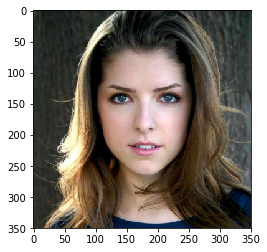

Total loss:  2116950.5


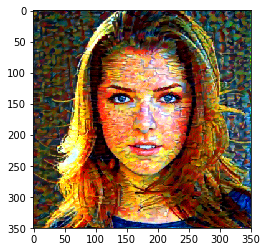

Total loss:  465002.15625


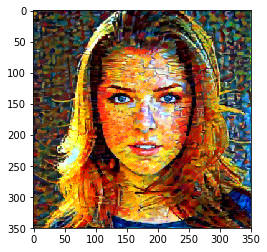

Total loss:  248838.1875


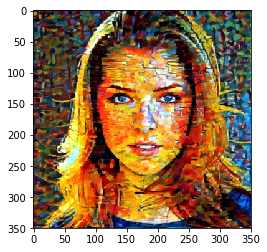

Total loss:  188102.96875


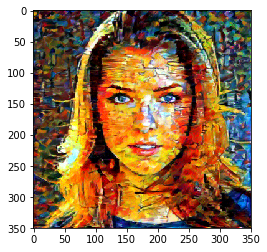

Total loss:  167595.25


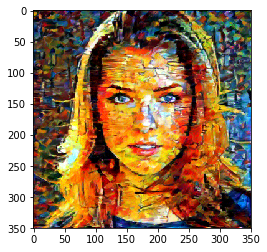

In [32]:
# for displaying the target image, intermittently
show_every = 3000

# iteration hyperparameters
optimizer = optim.Adam([target_img], lr=0.003)
epochs = 15000  # decide how many iterations to update your image

for ii in range(epochs+1):
    
    # clear optimizer grad
    optimizer.zero_grad()
    
    # get target features
    target_feats = get_features(target_img, vgg)
    
    # calculate content loss
    content_loss = layer_content_loss(content_feats['conv4_2'], target_feats['conv4_2'])
    
    # style loss
    style_loss = 0.0
    for layer in style_weighted_layers:
        # get target & style features
        target_feat = target_feats[layer]
        style_feat = style_feats[layer]
        style_weight = style_weighted_layers[layer]
        
        # calculate layer style loss (loss for each layer)
        style_loss += layer_style_loss(style_feat, target_feat, style_weight)
    
    # calculate the total loss
    total_loss = content_loss + style_loss/ab_ratio
    
    # backpropagate and optimiser step
    total_loss.backward()
    optimizer.step()
    
    # display intermediate images and print the loss
    if  ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(im_convert(target_img))
        plt.show()

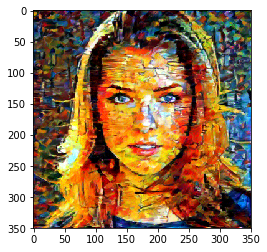

In [33]:
# final style-transfer result
plt.imshow(im_convert(target_img))
plt.show()